In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
import itertools

color = sns.color_palette()
%matplotlib inline

# Explore the data

The training data contains a row per comment, with an id, the text of the comment, and 6 different labels that we'll try to predict.


In [2]:
ddf = pd.read_csv('train.csv', header=0)
ddf.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


A common preprocessing step is to check for missing values (nulls), and fill them with something before proceeding to the next steps. If you leave the null values intact, it will trip you up at the modelling stage late

In [3]:
# Check for missing values in Train dataset ( 0 for no-missing value)
print("Check for missing values in Train dataset")
null_check=ddf.isnull().sum()
print(null_check)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [4]:
# Here's an example of comments with toxic label.
ddf.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

We get the lenght of commnet texts and plot the occurence

mean =  394.073221325
deviation =  590.720281905
maximum =  5000


Text(0.5,0,'text lenght ')

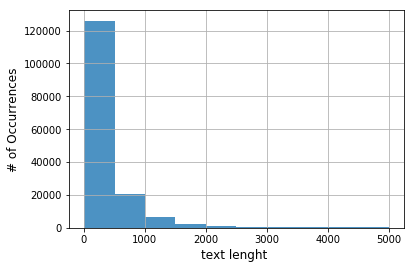

In [5]:
lens = ddf.comment_text.str.len()
print("mean = ", lens.mean())
print("deviation = ", lens.std())
print("maximum = ", lens.max()) 
lens.hist(alpha=0.8)
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('text lenght ', fontsize=12)

The maximum of text length is about 5000 word. we plot the number of occurence of each class

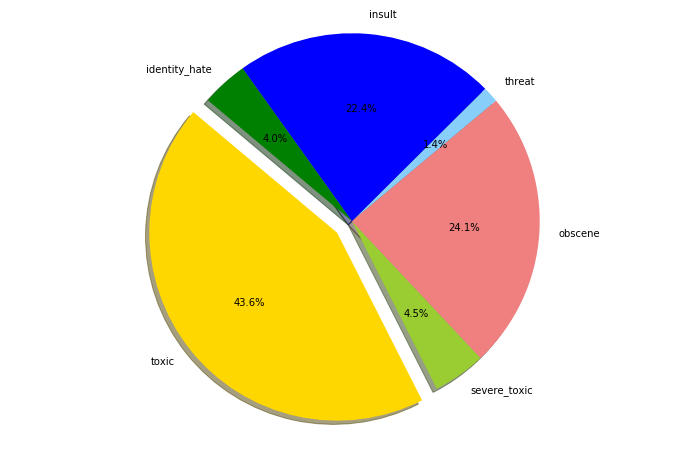

In [6]:
serie=ddf.iloc[:,2:].sum()
plt.figure(figsize=(12,8)) 
# Data to plot
labels = 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'
sizes = serie.values
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'blue', 'green']
explode = (0.1, 0, 0, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, labels=labels, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

The 6 classes are not repeated uniformly. We should check if there are the multitags cases !

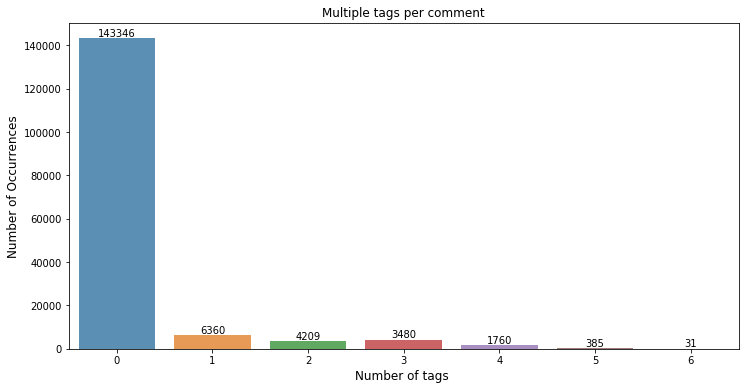

In [7]:
rowsums=ddf.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(12,6))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Multiple tags per comment")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

We see that the majority have no tags. 20 of samples have all tags.

# Data processing

In [8]:
# This module use regex in order to clean a text in dataframe df
def clean_up(text) :
    return re.sub(r'[\W]', ' ', text.lower() )

In [9]:
# We create a new label as a vector of set of tags
labels = []
for a,b,c,d,e,f in zip(ddf['toxic'], ddf['severe_toxic'], ddf['obscene'], ddf['threat'], ddf['insult'], 
                       ddf['identity_hate']): 
    labels.append([a,b,c,d,e,f])


# create a new dataframe with 'comment_text' and 'labels' columns
df1 = pd.concat([ddf['comment_text'], pd.DataFrame({'labels': labels})], axis = 1)

# and clean a 'comment_text' column
df1['comment_text'] = df1['comment_text'].apply(clean_up)
print(len(df1))

# find the duplicate rows
dupl_rows = df1.loc[df1.comment_text.duplicated(keep='first'), :]

# get the list index of duplicate rows
list_dupl_rows = dupl_rows.index.tolist()

# remove the duplicate rows
df1 = df1.drop(df1.index[list_dupl_rows])


df1.head()

159571


,comment_text,labels
0,explanation why the edits made under my userna...,"[0, 0, 0, 0, 0, 0]"
1,d aww he matches this background colour i m s...,"[0, 0, 0, 0, 0, 0]"
2,hey man i m really not trying to edit war it...,"[0, 0, 0, 0, 0, 0]"
3,more i can t make any real suggestions on im...,"[0, 0, 0, 0, 0, 0]"
4,you sir are my hero any chance you remember...,"[0, 0, 0, 0, 0, 0]"


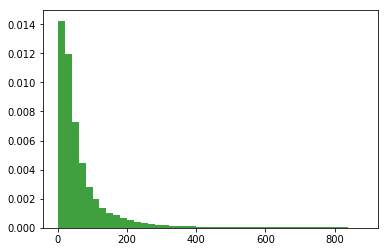

In [10]:
# We get the lenght of commnet texts and plot the occurence after cleaning
listo = [len(sentence.split()) for sentence in df1['comment_text']]
plt.hist(listo, bins = np.arange(0,900,20), normed=1, facecolor='green', alpha=0.75)
plt.show()

# LSTM model

The approach that we are taking is to feed the comments into the LSTM as part of the neural network but we can't just feed the words as it is. 

So this is what we are going to do:

    - We need to break down the sentence into unique words. For eg, "The sky is blue and the forest is green" will become ["The", "sky", "is", "blue", "and", "the", "forest", "is", "green"]
    - We put the words in a dictionary-like structure and give them an index each. For eg, {1: "The", 2: "sky", 3: "is", 4: "blue", 5: "and", 6: "forest", 7: "green"}. A way to find the index is to assign a unique integer to each symbol based on frequency of occurrence
    - We could represent the sequence of words in the comments in the form of index, and feed this chain of index into our LSTM. For eg, [1,2,3,4,5,1,6,3,7]



In [11]:
# the next module creates a list of unique words in all comment text of dataframe
def get_words(column):
    lista = [ elt.split() for elt in column ]
    list_of_words = list( itertools.chain.from_iterable(lista) )
    
    return list_of_words

In [12]:
# this module creates from text, a dictionary = {word: # of occurence in the text}
def dic_word_int(text):
    counts = Counter(text) # counts = {# of occurence in the text: word}
    vocab = sorted(counts, key=counts.get, reverse=True) # vocab = 'counts' sorted on descending occurence
    vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)} # vocab_to_int = the inverse of 'vocab'

    return vocab_to_int

We have to feed a stream of data that has a same length. We put the maximum length of sentence to 'seq_len'. For sentence which its length is less than this limite, we fill the shortfall by zeros ('padding').



If we put 'seq_len' too short, we might lose some useful feature that could cost us some accuracy points down the path. If we put it too long, our LSTM cell will have to be larger to store the possible values or states.

One of the ways to go about it is to use the histogram of sentences lengths showen above.

We see that the most sentences length is about 'seq_len=100'. but we could experiment and see what is the best length.


In [13]:
# This module builds new features and labels that we'll used in the model 
def extract_features(data_x, data_y, vocab_to_int, seq_len):
    text_ints = []
    vec = []
    for elt, sub in zip(data_x, data_y):
        # transforms each comment on vector of the occurence of words in each comment: 'list of the lists'
        text_ints.append([vocab_to_int[word] for word in elt.split()]) 
        # transforms labels on list of labels : [ [0,0,0,1,0,0], [0,0,0,1,1,1], [0,0,0,,0,0], ... ]
        vec.append([indice for indice in sub])
    
    # We limite the number of words on each comment in 'seq_len'. 
    # each 'word' will be a feature and will be identified by its occurence in the 'comment_text'
    # Sentences wich lenght is less than 'seq_len', should be padded with zeros
    features = np.zeros((len(text_ints), seq_len), dtype=int)
    labels = np.zeros((len(text_ints), 6), dtype=int)
    
    for i, row in enumerate(text_ints):
        # We take the last 'seq_len' words of each comment. The order of words is reversed in 'features'.
        features[i, -len(row):] = np.array(row)[:seq_len]
        
    for i, sub in enumerate(vec):
        labels[i, :] = np.array(sub)[:]
         
        
    return features, labels

In [14]:
# get the unique words from comment_text
words = get_words(df1['comment_text'])

# get a 'vocab_to_int' = {word: # of occurence in 'words}. The number of occurence is descending
vocab_to_int = dic_word_int(words)

Next, we pass it to our Embedding layer, where we project the words to a defined vector space depending on the distance of the surrounding words in a sentence. Embedding allows us to reduce model size and most importantly the huge dimensions we have to deal with, in the case of using one-hot encoding to represent the words in our sentence.

In [15]:
# We'll split the dataframe on train set (80%) and validation set (20%). 
# This validation set will be used to assess whether the model has overfitted, for each batch.
x_train, x_val, y_train, y_val = train_test_split(df1['comment_text'], df1['labels'], test_size=0.20, random_state=42)

In [16]:
# Create the new features and labels
seq_len = 100
train_x, train_y = extract_features(x_train, y_train, vocab_to_int, seq_len)
val_x, val_y =  extract_features(x_val, y_val, vocab_to_int, seq_len)

In [17]:
print(train_y.shape)
print(val_y.shape)

(127576, 6)
(31895, 6)


## Tensorflow

In [18]:
lstm_size = 256 # number of units in LSTM cell
lstm_layers = 1 # number of hidden layer
batch_size = 512 # number of batches
output_layer_size = 6 # number of classes
learning_rate = 0.001 # learning_rate
embed_size = 50 # Size of the embedding vectors (number of units in the embedding layer)
n_words = len(vocab_to_int) + 1 # Adding 1 because we use 0's for padding, dictionary started at 1
epochs = 10 # the number of time we'll train all data 

In [19]:
# we create the batches from 'permutation' of all samples
def get_batches(x, y, batch_size, seed):
    
    np.random.seed(seed)
    
    m = np.shape(y)[0]
    permutation = np.random.permutation(m)
    x, y = x[permutation], y[permutation]
    
    # number of batchs. We use only batches with same size: the rest of (m/batch_size) will be ignored 
    n_batches = m //batch_size
    
    x, y = x[: n_batches * batch_size], y[: n_batches * batch_size]
    for k in range(0, len(x), batch_size):
        yield x[k: k + batch_size], y[k: k + batch_size]

In [20]:
# this module will give the accuracy of predictions
def predict(Z, Y):
    # return a tensor of ones if the elements is > 0.5, otherwise zeros
    ZZ = tf.cast(tf.where( Z > 0.5, tf.ones(tf.shape(Z)), tf.zeros(tf.shape(Z)), name=None ), tf.int32)
    
    # compare the predicted tensor ZZ and the truth tensor Y: retun tensor of 0 (flase) and 1 (true) 
    comparaison = tf.cast(tf.equal(ZZ, Y), tf.int32) 
    
    # map function gives the sum of each element of 'comparaison'
    A = tf.map_fn(lambda x: tf.reduce_sum(x), comparaison)

    F = tf.where( A >= tf.shape(Z)[1], tf.ones(tf.shape(A)), tf.zeros(tf.shape(A)), name=None )
    
    # get the lenght of Z
    m = tf.cast(tf.shape(Z)[0], tf.float32)
     
    accura = 100 * tf.reduce_sum(F) / m
    
    return accura

<img src="fig1.png" style="width:650px;height:1200;">

In [21]:
# Let's build the graph of tensorflow
graph = tf.Graph() # get the instance

# Add nodes to the graph
with graph.as_default():
    # create instances for the imputs, labels and the probability of drop out
    inputs_ = tf.placeholder(tf.int32, [None, None], name='inputs')
    labels_ = tf.placeholder(tf.int32, [None, None], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob') 

    # create instances for embedding tensor with shape (n_words, embed_size)
    # each word from 'n_words' will be represented by vector with size 'embed_size' 
    # the initialization will be done through uniform distribution
    embedding = tf.Variable(tf.random_uniform((n_words, embed_size), -1, 1))
    
    # With 'embed', we project the words of 'inputs_' to a defined vector space depending on the distance of 
    # the surrounding words in a sentence. The output 'embed' is just a list of the coordinates 
    # of the words in this vector space.
    embed = tf.nn.embedding_lookup(embedding, inputs_)
    
    # The basic LSTM cell with 'lstm_size' units
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    
    # Add dropout to the cell
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    
    # Getting an initial state of all zeros. This is the memory of LSTM cell
    initial_state = cell.zero_state(batch_size, tf.float32)
    
    outputs, final_state = tf.nn.dynamic_rnn(cell, embed,initial_state=initial_state)
    
    # We connect the outputs to a densely connected layer and the output passes through a sigmoid functions.
    # The reason why sigmoid is used is because we are trying to achieve a binary classification(1,0) 
    # for each of the 6 tags, and the sigmoid function will squash the output between the bounds of 0 and 1.
    predictions = tf.contrib.layers.fully_connected(inputs=outputs[:, -1], num_outputs = output_layer_size, 
                                                    activation_fn=tf.sigmoid)
    
    # We have set our model to optimize our loss function using Adam optimizer, define the loss function to 
    # be "binary_crossentropy" since we are tackling a binary classification. 
    cost = tf.losses.sigmoid_cross_entropy(labels_, predictions)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    # We get accuracy from comparing between predictions given by the model and the labels
    accuracy = predict(predictions, labels_)
    
    # create 'Save' instance in order to save the model
    saver = tf.train.Saver()

In [22]:
# create the file name in which we save the model
save_file = 'models/toxic_tensorflow_model.ckpt'

# create the tensorflow session with previous graph
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer()) # initialize all variables
    iteration = 1
    epoch_loss = [] # list to store all losse values
    seed = 0
    for epoch in range(epochs):
        state = sess.run(initial_state)
        seed += 1
        
        # for each batche in training data set
        for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size, seed), 1):
            
            # create a dictionary of inputs 'x', labels 'y' and a fixed probability value of the number 
            # of unit in LSTM cell to drop out
            feed = {inputs_: x, labels_: y, keep_prob: 0.5, initial_state: state}
            # Run the nodes 'cost', 'final_state' and 'optimizer' to get the 'loss' and the 'state'
            loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)
            
            
            epoch_loss.append(loss) # store the loss
            if iteration%100==0: # Show the loss after each 100 iterations
                print("Epoch: {}/{}".format(epoch, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {}".format(loss))

            if iteration%500==0: # After 500 iteration, get the accuracy of the validation data set
                val_acc = [] # list to store validation accuracy
                val_state = sess.run(cell.zero_state(batch_size, tf.float32)) # initialise the memory state to 0
                
                # for each batche in validation data set 
                for x, y in get_batches(val_x, val_y, batch_size, seed):
                    # create a 'feed' dictionary
                    feed = {inputs_: x, labels_: y, keep_prob: 1, initial_state: val_state}
                    # Run the nodes 'accuracy' and 'final_state' to get the accuracy of the batch and the validation state
                    batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                    val_acc.append(batch_acc)
                
                
                print("Val acc: {}".format(np.mean(val_acc))) # Show the mean of accuracy 
            iteration +=1
    # save the model
    saver.save(sess, save_file)

Epoch: 0/10 Iteration: 100 Train loss: 0.6932229995727539
Epoch: 0/10 Iteration: 200 Train loss: 0.6931931376457214
Epoch: 1/10 Iteration: 300 Train loss: 0.6931735873222351
Epoch: 1/10 Iteration: 400 Train loss: 0.6931633353233337
Epoch: 2/10 Iteration: 500 Train loss: 0.694130003452301
Val acc: 89.6484375
Epoch: 2/10 Iteration: 600 Train loss: 0.6931567788124084
Epoch: 2/10 Iteration: 700 Train loss: 0.6931557655334473
Epoch: 3/10 Iteration: 800 Train loss: 0.6931532025337219
Epoch: 3/10 Iteration: 900 Train loss: 0.6931517720222473
Epoch: 4/10 Iteration: 1000 Train loss: 0.6931514143943787
Val acc: 89.63268280029297
Epoch: 4/10 Iteration: 1100 Train loss: 0.6931508183479309
Epoch: 4/10 Iteration: 1200 Train loss: 0.693149745464325
Epoch: 5/10 Iteration: 1300 Train loss: 0.6931502223014832
Epoch: 5/10 Iteration: 1400 Train loss: 0.6931493878364563
Epoch: 6/10 Iteration: 1500 Train loss: 0.6931487917900085
Val acc: 89.62638854980469
Epoch: 6/10 Iteration: 1600 Train loss: 0.6931483745

After 10 epochs, we get 89.64% as validation accuracy

## Keras
With tensorflow, we implemented our own dictionary structure and handle the indexing ourself. In Keras, all the above steps can be done in 4 lines of code. Fortunately, Keras has made our lives so much easier.

In [22]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [23]:
df2 = ddf

# create labels from the tags columns
coloumns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_y = df2[coloumns].values

# create a list of all sentences in "comment_text" coumn
train_sentences = df2["comment_text"]

Note: In Tensorflow we have used all words given in the texts. Here with Keras, we choose to limite to 2000 first most occurent words

In [24]:
# We use only the most frequently 'top_words' for simplicity
top_words = 20000 

# create the instance of 'Tokenizer' with the maximum of dictionary's words
tokenizer = Tokenizer(num_words=top_words) 

# As same as the modules 'def get_words' and 'dic_word_int', the nexte module will create words dictionary from 'sentences'
tokenizer.fit_on_texts(list(train_sentences))

# transforms each comment on vector of the occurence of words based on the previous dictionary
list_tokenized_train = tokenizer.texts_to_sequences(train_sentences)

# for sentence wich length is less than 200, fill the reste with 0 (padding)
seq_len = 200
train_x = pad_sequences(list_tokenized_train, maxlen=seq_len)

In [25]:
# create the model
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence



# here we'll change some hyperparameters for simplicirty
embed_size = 32
LSTM_size = 100
batch_size=256
epochs=10
save_file = 'models/toxic_lastm_keras_model.h5'

model = Sequential()

# enbedding layer
model.add(Embedding(top_words, embed_size, input_length=seq_len))

# one LSTM layer
model.add(LSTM(LSTM_size)) 

# fully connected layer
model.add(Dense(output_layer_size, activation='sigmoid')) 

# define a loss, potimizer and accuracu functions
# we use adam optimizer where the learning rate is 'lr=0.001' by default
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
# we can set:  my_adam = optimizers.Adam(lr=learning_rate) and model.compile(loss='binary_crossentropy', ...)

# print the summary of the model
print(model.summary())

#train the model
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# save the model
model.save(save_file)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 693,806
Trainable params: 693,806
Non-trainable params: 0
_________________________________________________________________
None
Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 1461s 10ms/step - loss: 0.1214 - acc: 0.9668 - val_loss: 0.0666 - val_acc: 0.9761
Epoch 2/10
143613/143613 [==============================] - 1508s 10ms/step - loss: 0.0601 - acc: 0.9784 - val_loss: 0.0575 - val_acc: 0.9793
Epoch 3/10
143613/143613 [==============================] - 

After 10 epochs, we get 98.12% as validation accuracy which is best than the Tensorflow one. This is due to the fact that in keras, we used only 20000 words (top_words) of the dictionary. But it remains that with keras the data processing and the implementation of the graph are more intuitive than tensorflow